**State Predictive Information Bottleneck (RAVE)**


**Authors** Itamar Perez Ryan, Joshua Layfield 


**Start Date** July 13, 2023



**Aims**
We are attempting to adapt the notebook used in the PLUMED Masterclass (https://github.com/tiwarylab/SPIB-plumed-masterclass-2022) by Dr. Pratyush Tiwary. 

We are attempting to build an SPIB model to study the folding of the C-terminus of the GB1 protein and explore the free-energy surface with an ulitmate goal of studying TrpZip like peptides. 


**Prerequisites**

We are starting to work with doing the pytorch systems on a MacBook Pro or iMac with GPU supports but may need to move to clusters with better GPUs.


**Objectives**

1.   Use SPIB to analyze different COLVAR files 
2.   Use SPIB to perform biased metadynamics simulations on the C-terminus of the GB1 protein (referred to as 1gb1 hereafter). 




**Step 0.0**: 
<br>We have created a python kernel that contains all of the needed libraries (mainly pytorch but many others). </br>

Here is an approximate list for needed libraries:
- Numpy
- MatPlotLib
- Pytorch
- Plumed

- Gromacs (to run dynamics but we are going to move back and forth to raven) 
    (This may need to be on a separate environment with x86_64 architechture)
    
**Make sure that the pytorch kernel is active**

**Step 0.1**: 
<br>Load necessary python libraries and matplotlib graph visualization parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
import sys
import pandas as pd
import seaborn as sns

sys.path.append('SPIB_scripts/')
np.random.seed(42)

large = 24; med = 12; small = 8
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': 20,
          'legend.title_fontsize':20,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 2,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

**Step 1**: 


Access the files needed for the SPIB method. We will start by analyzing a long unbiased trajectory of GB1 from a numpy array. The file is called `350.npy`.

Load the unbiased trajectory -> visualize the OPs time series -> create a free energy plot for the entire trajectory.

Number of saved frames:  4000001 , Number of features:  4
features: rg hb rmsd nc


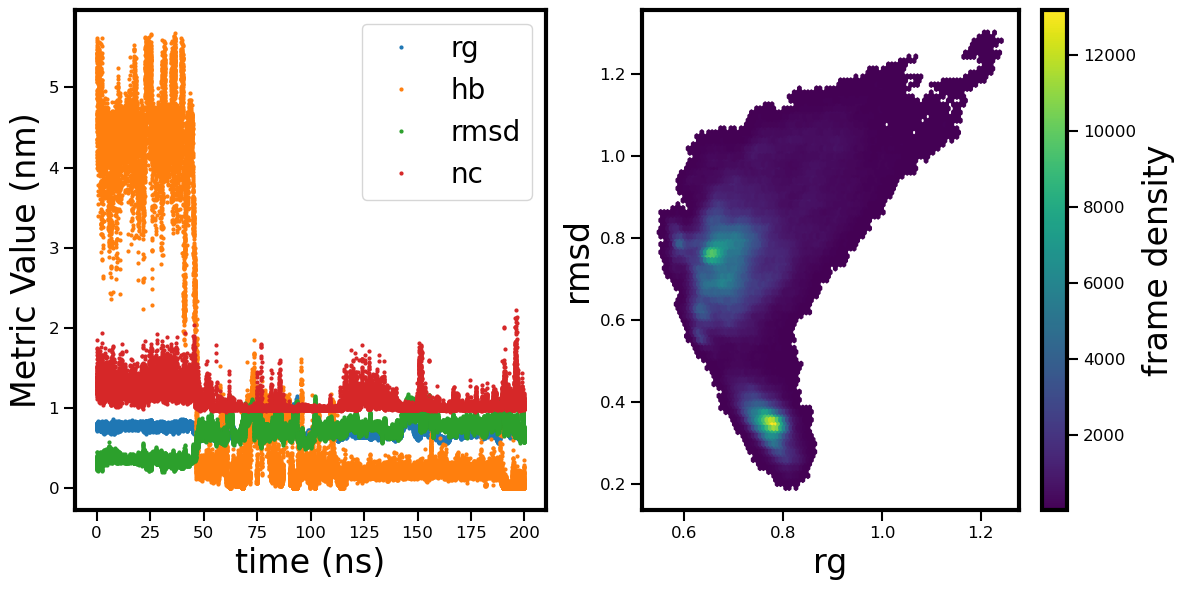

In [11]:
input_file='../350.npy'
traj_raw = np.load(input_file)
features = ['rg', 'hb', 'rmsd', 'nc']

print('Number of saved frames: ', traj_raw.shape[0], ', Number of features: ', traj_raw.shape[1]-1)
print('features:', *features)

## Loaded numpy arrays contain datapoints saved every 0.05ps. The first 2000 steps (100.00 ps) are selected for time series visualization
# data_resolution = 1.00
datapoints_tseries = 5000
time = traj_raw[:,0] # time i
traj_raw = traj_raw[:,1:]

fig, ax = plt.subplots(1, 2, figsize = (12,6))
# ## Time Series plot
for i in range(traj_raw.shape[1]):
    ax[0].plot(time[::100]/1000., traj_raw[::100,i], 'o', label = features[i])
ax[0].set_xlabel('time (ns)')
ax[0].set_ylabel('Metric Value (nm)')
ax[0].legend()


feature1=0
feature2=2
# ## FES plot of entire trajectory
fes = ax[1].hexbin(traj_raw[:,feature1], traj_raw[:,feature2], mincnt=1)
ax[1].set_xlabel(features[feature1])
ax[1].set_ylabel(features[feature2])
cb = fig.colorbar(fes, ax=ax[1])
cb.set_label('frame density')
fig.tight_layout()
fig.savefig('Unbiased.png')

/Users/layf0001/miniconda3/envs/pytorch/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


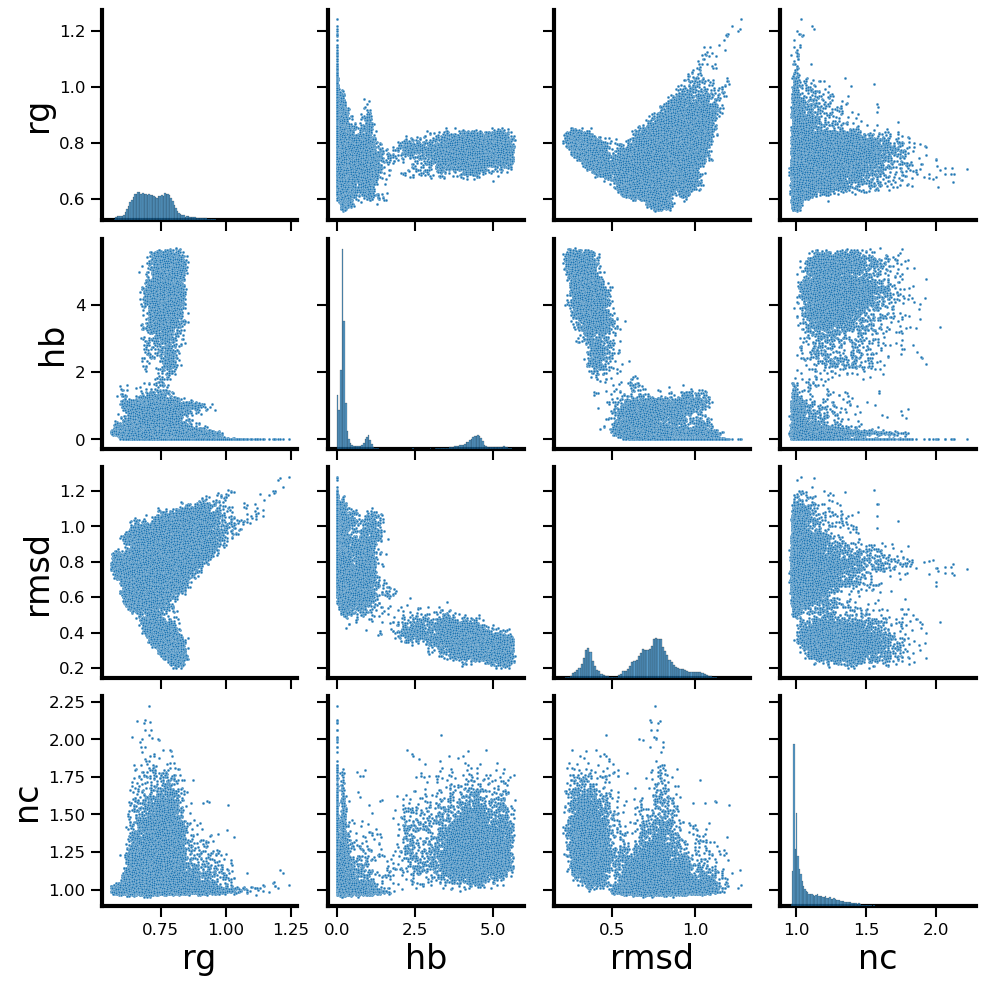

In [13]:
df = pd.DataFrame(traj_raw[::100], columns=features)
sns.pairplot(df)

**Step 3**:Assign initial states by binning data along two OPs:
1. The RMSD from the folded structure
2. Radius of Gyration for the $\alpha$-carbons 

This requires a 2-d digitize scheme. 

Total Labels: 25


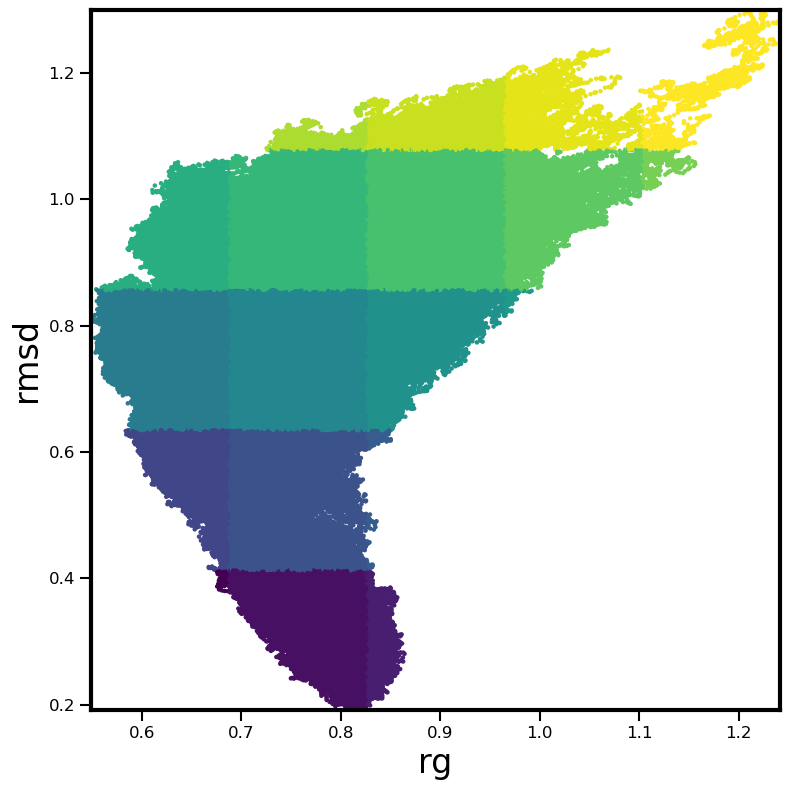

In [15]:
#@title One-hot encoded initial state assignment
num_0 = 5
num_1 = 5
num_labels = num_0*num_1 
print(f'Total Labels: {num_labels}')
# 25 initial states assigned to the trajectory by creating a 2-d grid along Rg and AB.

# Indices for the initial assignment
index_0 = feature1
index_1 = feature2

x_min = traj_raw[:,index_0].min()
x_max = traj_raw[:,index_0].max()
y_min = traj_raw[:,index_1].min()
y_max = traj_raw[:,index_1].max()



bin_0 = np.linspace(start=x_min, stop=x_max, num = num_0, endpoint = False)
bin_1 = np.linspace(start=y_min, stop=y_max, num = num_1, endpoint = False)

binned_0 = np.digitize(traj_raw[:,index_0], bin_0)-1
binned_1 = np.digitize(traj_raw[:,index_1], bin_1)-1 


one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))

final_label = binned_1*num_0+binned_0
one_hot_labels[np.arange(traj_raw.shape[0]), final_label] = 1

# Creating one hot vectors for initial states
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(traj_raw[:, index_0], traj_raw[:, index_1], c=final_label, s=5, alpha=1)
# ax.set_title('Initial state assignments')
ax.set_xlabel(features[index_0])
ax.set_ylabel(features[index_1])
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
fig.tight_layout()
fig.savefig('Initial.png')
# Save one-hot encoded initial states
np.save("inputs/labels.npy", one_hot_labels)
np.save("inputs/new_ops.npy", traj_raw)

**Step 4**:<br>
Train a nonlinear SPIB (ver July, 2021) model by choosing appropriate hyperparmeters.

---

Time delay = dt*0.05 ps, heuristic for batch size = 0.1% of trajectory length

In [9]:
#@title Select SPIB hyperparameters
## Train an SPIB model with time delay = 0.25 ps

dt = 5 #@param {type:"integer"}
rc_dim = 2 #@param {type:"integer"}
encoder_type = 'Nonlinear' #@param {type:"string"}
neuron_num1 = 16 #@param {type:"integer"}
neuron_num2 = 16 #@param {type:"integer"}
## heuristic for batch size is to set it ~ 0.1% of the trajectory length
batch_size = 2048 #@param {type:"integer"}
refinements = 15 #@param {type:"integer"}
learning_rate = 0.0001 #@param {type:"number"}
beta = 0.001 #@param {type:"number"}
seed = 0 #@param {type:"integer"}
traj_path = 'inputs/new_ops.npy'
initial_states_path = 'inputs/labels.npy'
SPIB_OPs = traj_raw.shape[1]
Weighted_or_not = 'Unweighted'

In [10]:
# Train SPIB model
!conda run -n pytorch python SPIB_scripts/test_model.py -dt {dt} -d {rc_dim} -encoder_type {encoder_type} -bs {batch_size} -n1 {neuron_num1} -n2 {neuron_num2} -refinements {refinements} -lr {learning_rate} -b {beta} -seed {seed} -label {initial_states_path} -traj {traj_path}


Iteration 500:	Time 14.277786 s
Loss (train) 2.754559	KL loss (train): 0.932121
Reconstruction loss (train) 2.753627
Loss (test) 2.749548	KL loss (test): 0.927226
Reconstruction loss (test) 2.748621
Iteration 1000:	Time 22.420107 s
Loss (train) 1.865089	KL loss (train): 2.706800
Reconstruction loss (train) 1.862382
Loss (test) 1.839397	KL loss (test): 2.726379
Reconstruction loss (test) 1.836670
Iteration 1500:	Time 30.549190 s
Loss (train) 1.460997	KL loss (train): 2.674154
Reconstruction loss (train) 1.458323
Loss (test) 1.516952	KL loss (test): 2.749340
Reconstruction loss (test) 1.514203
tensor([0.0000, 0.2302, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6599, 0.1099, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
State population change=0.434592
Epoch: 1

Iteration 2000:	Time 42.278971 s
Loss (train) 1.388153	KL loss (train): 2.821195
Reconstruction loss (train) 1.385332
Loss (test) 1.4

**Step 5**:
<br>Visualize converged SPIB states

In [11]:
## Number of trajectories in this analysis
num_traj = 1
## Construct file path from chosen hyperparameter values
path = "SPIB/" + Weighted_or_not + "_d=" + str(rc_dim) + "_t=" + str(dt) + "_b=" + "{:.4f}".format(beta) + "_learn=" + "{:.6f}".format(learning_rate)

one_hot_converged_labels = np.load(path + "_traj" + str(num_traj-1) + "_labels" + str(seed) + ".npy")
converged_labels = np.zeros((one_hot_converged_labels.shape[0]), dtype = 'int')

for i in range(converged_labels.shape[0]):
  converged_labels[i] = np.nonzero(one_hot_converged_labels[i,:])[0]



/var/folders/dn/mw60gh5x4j17k1mx996w5_8c0000gq/T/ipykernel_14603/80820493.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  converged_labels[i] = np.nonzero(one_hot_converged_labels[i,:])[0]


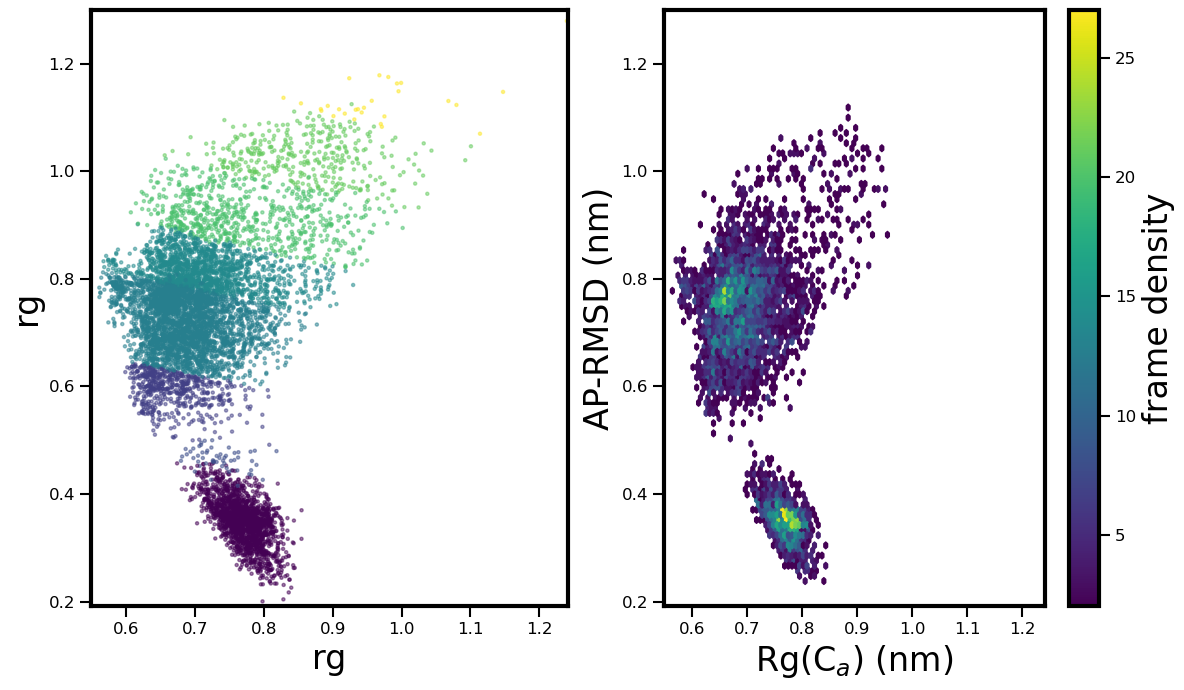

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12,7))
ax[0].scatter(traj_raw[::500, index_0], traj_raw[::500, index_1], c=converged_labels[::500], s=5, alpha=0.5)
# plt.suptitle('Converged SPIB states')
ax[0].set_xlabel(features[index_0])
ax[0].set_ylabel(features[index_0])
ax[0].set_xlim((x_min,x_max))
ax[0].set_ylim((y_min,y_max))

# ## FES plot of entire trajectory
fes = ax[1].hexbin(traj_raw[::500,index_0], traj_raw[::500,index_1], mincnt=2)
ax[1].set_xlabel('Rg(C$_a$) (nm)')
ax[1].set_ylabel('AP-RMSD (nm)')
ax[1].set_xlim((x_min,x_max))
ax[1].set_ylim((y_min,y_max))
cb = fig.colorbar(fes, ax=ax[1])
cb.set_label('frame density')
fig.tight_layout()
fig.savefig('Unbiased.png')
fig.savefig('First Assignment.png')

**Step 6**: Create plumed input from saved SPIB model

In [13]:
# Note: When encountering following error: "module SPIB has no attribute SPIB", restart runtime and run all except SPIB training cell.
#@title Metadynamics parameters
sigma_mul = 0.2 #@param {type:"number"}
grid_mul = 5 #@param {type:"number"}
height = 1.5 #@param {type:"number"}
bias_factor = 10 #@param {type:"number"}
pace = 2000 #@param {type:"integer"}
stride = 100 #@param {type:"integer"}
grid_bins = 500 #@param {type:"integer"}
file_name = "plumed_SPIB_.dat" #@param {type:"string"}

import torch
from torch import nn
import SPIB


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "SPIB/" + Weighted_or_not + "_d=" + str(rc_dim) + "_t=" + str(dt) + "_b=" + "{:.4f}".format(beta) + "_learn=" + "{:.6f}".format(learning_rate)

data_shape=SPIB_OPs
# Update Label should be set to False for testing purposes only
UpdateLabel = True
# Load patameters from SPIB checkpoint
restore_path= path + 'cpt0/IB_final_cpt.pt'
representative_inputs_path=path + '_representative_inputs' + str(seed) + '.npy'
representative_inputs = torch.tensor(np.load(representative_inputs_path))
IB = SPIB.SPIB(encoder_type, rc_dim, num_labels, data_shape, device, UpdateLabel, neuron_num1, neuron_num2)
IB.reset_representative(representative_inputs)
checkpoint=torch.load(restore_path)
IB.load_state_dict(checkpoint['state_dict'])

weight0=IB.encoder[0].weight.cpu().data.numpy()
weight1=IB.encoder[2].weight.cpu().data.numpy()
weight2=IB.encoder_mean.weight.cpu().data.numpy()
bias0=IB.encoder[0].bias.cpu().data.numpy()
bias1=IB.encoder[2].bias.cpu().data.numpy()
bias2=IB.encoder_mean.bias.cpu().data.numpy()

with open('new-inputs/new-header.txt', 'r') as f:
  head = f.read()
header = head + "\n"

## Calculate standard deviation of the RC and mutiply by sigma_mul to obtain sigma for metadynamics
traj_rc = np.load(path + "_traj" + str(num_traj-1) + "_mean_representation" + str(seed) + ".npy")
rc1_sigma = np.std(traj_rc[:,0])*sigma_mul
rc2_sigma = np.std(traj_rc[:,1])*sigma_mul  

## Set grid_min and grid_max
rc1_grid_min = np.min(traj_rc[:,0]) - grid_mul*rc1_sigma
rc2_grid_min = np.min(traj_rc[:,1]) - grid_mul*rc2_sigma

rc1_grid_max = np.max(traj_rc[:,0]) + grid_mul*rc1_sigma
rc2_grid_max = np.max(traj_rc[:,1]) + grid_mul*rc2_sigma

OPs = features
with open(file_name, 'w') as f:
    f.writelines(header)
    f.write('\n')
    
    input_OPs = ''
    for i in range(len(OPs)):
      input_OPs += OPs[i]+','
    # 1st layer
    for i in range(weight0.shape[0]):
        toprint = f"l1_{i+1}: COMBINE ARG=" + input_OPs   
        toprint = toprint[:-1] + " COEFFICIENTS="
        for j in range(weight0.shape[1]):
            toprint = toprint + "%0.12f," % (weight0[i,j])
        toprint = toprint[:-1] + " PERIODIC=NO\n"
        f.write(toprint)
    for i in range(weight0.shape[0]):
        onebias = bias0[i]
        # Relu as activation function
        if onebias >= 0:
            printfun = "step(x+%0.12f)*(x+%0.12f)" % (onebias,onebias)
        else:
            printfun = "step(x-%0.12f)*(x-%0.12f)" % (-onebias,-onebias)
        f.write("l1r_%i: MATHEVAL ARG=l1_%i FUNC=%s PERIODIC=NO\n" % (i+1,i+1,printfun))
    
    # 2nd layer
    for i in range(weight1.shape[0]):
        toprint = "l2_%i: COMBINE ARG=" % (i+1)
        for j in range(weight0.shape[0]):
          toprint = toprint + "l1r_%i," % (j+1)
        toprint = toprint[:-1] + " COEFFICIENTS="
        for j in range(weight0.shape[0]):
          toprint = toprint + "%0.12f," % (weight1[i,j])
        toprint = toprint[:-1] + " PERIODIC=NO\n"
        f.write(toprint)
    for i in range(weight1.shape[0]):
        onebias = bias1[i]
        # Relu as activation function
        if onebias >= 0:
            printfun = "step(x+%0.12f)*(x+%0.12f)" % (onebias,onebias)
        else:
            printfun = "step(x-%0.12f)*(x-%0.12f)" % (-onebias,-onebias)
        f.write("l2r_%i: MATHEVAL ARG=l2_%i FUNC=%s PERIODIC=NO\n" % (i+1,i+1,printfun))
        
    # 3rd layer/Linear Output
    for i in range(weight2.shape[0]):
        toprint = "l3_%i: COMBINE ARG=" % (i+1)
        for j in range(weight1.shape[0]):
          toprint = toprint + "l2r_%i," % (j+1)
        toprint = toprint[:-1] + " COEFFICIENTS="
        for j in range(weight1.shape[0]):
          toprint = toprint + "%0.12f," % (weight2[i,j])
        toprint = toprint[:-1] + " PERIODIC=NO\n"
        f.write(toprint)
    
    output_variable=''
    for i in range(weight2.shape[0]):
        output_variable=output_variable+"l3_%i," % (i+1)
    output_variable=output_variable[:-1]
    
    f.write(f'\nMETAD ...\nLABEL=metad\nARG='+output_variable+f' SIGMA={rc1_sigma},{rc2_sigma} HEIGHT={height} BIASFACTOR={bias_factor} TEMP=450.0 PACE={pace}\nGRID_MIN={rc1_grid_min},{rc2_grid_min} GRID_MAX={rc1_grid_max},{rc2_grid_max} \nCALC_RCT\n... METAD\n')
    f.write('\n')
            
    f.write('\nPRINT ARG='+input_OPs+output_variable+',metad.bias,metad.rbias'+f' STRIDE={stride} FILE=COLVAR')